In [ ]:
import os
os.environ['CUDA_HOME'] = '/usr/lib/cuda'
os.environ['CUDA_PATH'] = '/usr/lib/cuda/bin'

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

In [ ]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings
import torch
import pandas as pd
import numpy as np

from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model import TransformerModel
from scgpt.utils import set_seed 
from scgpt.tasks import GeneEmbedding

warnings.filterwarnings('ignore')
set_seed(42)

In [ ]:
# Specify paths
file_path = '../BEELINE-data/inputs/Curated/mCAD/mCAD-2000-1/ExpressionData.csv'
model_dir = Path("../models/scGPT_all_model/scGPT_human")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

In [ ]:
# Load vocabulary
vocab = GeneVocab.from_file(vocab_file)
special_tokens = ["<pad>", "<cls>", "<eoc>"]
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

In [ ]:
with open(model_config_file, "r") as f:
    model_configs = json.load(f)

In [ ]:
# Initialize model
ntokens = len(vocab)
model = TransformerModel(
    ntokens,
    model_configs["embsize"],
    model_configs["nheads"],
    model_configs["d_hid"],
    model_configs["nlayers"],
    vocab=vocab,
    pad_value=model_configs.get("pad_value", -2),
    n_input_bins=model_configs.get("n_bins", 51),
)


In [ ]:
# Load model weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dict = torch.load(model_file, map_location=device)

# Filter out unexpected keys
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in state_dict.items() if k in model_dict and v.shape == model_dict[k].shape}
model_dict.update(pretrained_dict)

# Load the filtered state dict
model.load_state_dict(model_dict, strict=False)
model.to(device)
model.eval()

In [ ]:
# Load and preprocess data
expression_data = pd.read_csv(file_path, index_col=0)
gene_names = expression_data.index.tolist()

# Tokenize genes
tokenized_genes = [vocab[gene] for gene in gene_names]

# Convert expression data to tensor
expression_tensor = torch.tensor(expression_data.values, dtype=torch.float32).to(device)

In [ ]:
# Generate embeddings
gene_ids = np.array([vocab[gene] for gene in gene_names])
with torch.no_grad():
    gene_embeddings = model.encoder(torch.tensor(gene_ids, dtype=torch.long).to(device))
gene_embeddings = gene_embeddings.detach().cpu().numpy()

# Create a dictionary of gene embeddings
gene_embeddings_dict = {gene: gene_embeddings[i] for i, gene in enumerate(gene_names)}

# Construct gene embedding network
embed = GeneEmbedding(gene_embeddings_dict)

print(f'Retrieved gene embeddings for {len(gene_embeddings_dict)} genes.')

In [ ]:
folder_path = './1024_Model_GEmbeds/'
embedding_df = pd.DataFrame(gene_embeddings, index=gene_names)
# Construct the full file path
file_path = os.path.join(folder_path, 'GE_MS_mCAD-2000-1.csv')

# Save the DataFrame to CSV
embedding_df.to_csv(file_path)

print("Done")

## Trying to figure out the PIDC nan value generation problem

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import KBinsDiscretizer

# Function to read the CSV file
def read_gene_embeddings(file_path):
    # Read the CSV file
    # Assuming the first column contains gene names and should be used as index
    df = pd.read_csv(file_path, index_col=0)
    return df

# Equal-width binning function
def equal_width_binning(df, n_bins=10):
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    discretized_data = discretizer.fit_transform(df)
    return pd.DataFrame(discretized_data, index=df.index, columns=df.columns)

# Equal-frequency binning function
def equal_frequency_binning(df, n_bins=10):
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    discretized_data = discretizer.fit_transform(df)
    return pd.DataFrame(discretized_data, index=df.index, columns=df.columns)

# Main process
def main():
    # Specify the path to your input CSV file
    input_file = './512_Model_GEmbeds/GE_VSC-2000-1.csv'
    
    # Read the gene embeddings
    df = read_gene_embeddings(input_file)
    
    # Print some information about the data
    print(f"Loaded data shape: {df.shape}")
    print(f"First few rows:\n{df.head()}")
    
    # Apply discretization
    df_equal_width = equal_width_binning(df)
    df_equal_freq = equal_frequency_binning(df)
    
    # Save the discretized data
    df_equal_width.to_csv('discretized_equal_width_VSC_512.csv')
    df_equal_freq.to_csv('discretized_equal_freq_VSC_512.csv')
    
    print("Discretization complete. Files saved as 'discretized_equal_width.csv' and 'discretized_equal_freq.csv'")

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
import matplotlib.pyplot as plt

def read_gene_embeddings(file_path):
    return pd.read_csv(file_path, index_col=0)

def analyze_data(df):
    print(f"Data shape: {df.shape}")
    print(f"\nData description:\n{df.describe()}")
    
    plt.figure(figsize=(10, 6))
    df.hist(bins=50)
    plt.tight_layout()
    plt.savefig('data_distribution.png')
    plt.close()
    
    print("\nHistogram saved as 'data_distribution.png'")

def remove_outliers(df, z_threshold=3):
    z_scores = np.abs((df - df.mean()) / df.std())
    return df[(z_scores < z_threshold).all(axis=1)]

def normalize_data(df):
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(df)
    return pd.DataFrame(normalized_data, index=df.index, columns=df.columns)

def custom_binning(df, n_bins=10):
    def custom_bin(column, n_bins):
        return pd.cut(column, bins=n_bins, labels=False, include_lowest=True)
    
    return df.apply(lambda col: custom_bin(col, n_bins))

def discretize_data(df, method='equal_width', n_bins=10):
    if method == 'equal_width':
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    elif method == 'equal_freq':
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    elif method == 'custom':
        return custom_binning(df, n_bins)
    else:
        raise ValueError("Invalid method. Choose 'equal_width', 'equal_freq', or 'custom'.")
    
    discretized_data = discretizer.fit_transform(df)
    return pd.DataFrame(discretized_data, index=df.index, columns=df.columns)

def main():
    input_file = './512_Model_GEmbeds/GE_VSC-2000-1.csv'
    df = read_gene_embeddings(input_file)
    
    analyze_data(df)
    
    df_no_outliers = remove_outliers(df)
    df_normalized = normalize_data(df_no_outliers)
    
    methods = ['equal_width', 'equal_freq', 'custom']
    n_bins_options = [5, 10, 20]
    
    for method in methods:
        for n_bins in n_bins_options:
            discretized_df = discretize_data(df_normalized, method=method, n_bins=n_bins)
            discretized_df.to_csv(f'discretized_{method}_bins{n_bins}.csv')
            print(f"Saved discretized data using {method} method with {n_bins} bins")
            
            # Check if all values are zero
            if (discretized_df == 0).all().all():
                print(f"Warning: All values are zero for {method} method with {n_bins} bins")
            
            # Print some statistics
            print(discretized_df.describe())
            print("\n")

if __name__ == "__main__":
    main()

### Modified code to solve same value error

In [ ]:
#Run import file and model script before this

def analyze_data(data):
    print(f"Data shape: {data.shape}")
    print(f"Mean: {data.mean().mean():.4f}")
    print(f"Std: {data.std().mean():.4f}")
    print(f"Min: {data.min().min():.4f}")
    print(f"Max: {data.max().max():.4f}")

def check_vocab_coverage(genes, vocab):
    found = sum(1 for gene in genes if gene in vocab)
    print(f"Vocabulary coverage: {found / len(genes) * 100:.2f}%")

expression_data = pd.read_csv(file_path, index_col=0)
gene_names = expression_data.index.tolist()

print("Input data statistics:")
analyze_data(expression_data)
check_vocab_coverage(gene_names, vocab)

tokenized_genes = [vocab[gene] if gene in vocab else vocab["<unk>"] for gene in gene_names]

expression_tensor = torch.tensor(expression_data.values, dtype=torch.float32).to(device)

gene_ids = torch.tensor([vocab[gene] if gene in vocab else vocab["<unk>"] for gene in gene_names], dtype=torch.long).to(device)
with torch.no_grad():
    gene_embeddings = model.encoder(gene_ids)
gene_embeddings = gene_embeddings.detach().cpu().numpy()

print("Output embedding statistics:")
analyze_data(pd.DataFrame(gene_embeddings))

print("Sample embeddings:")
for i in range(min(5, len(gene_names))):
    print(f"{gene_names[i]}: {gene_embeddings[i][:5]}...")

In [ ]:
print("Sample vocabulary entries:")
print(list(vocab.stoi.keys())[:10])

In [ ]:
print("Sample gene names from your data:")
print(gene_names[:10])  # Print first 10 gene names

In [ ]:
folder_path = './1024_Model_GEmbeds/'
embedding_df = pd.DataFrame(gene_embeddings, index=gene_names)
# Construct the full file path
file_path = os.path.join(folder_path, 'GE_MS_mCAD-2000-1.csv')

# Save the DataFrame to CSV
embedding_df.to_csv(file_path)

print("Done")

## Visualizing the final scores

### 1. GSD Datasets

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Creating the data as pandas DataFrame
data = {
    'Dataset': ['GSD Embeddings', 'GSD Embeddings', 'GSD Embeddings', 'GSD Expression', 'GSD Expression', 'GSD Expression',
                'GSD Equal Frequency', 'GSD Equal Frequency', 'GSD Equal Frequency', 'GSD Equal Width', 'GSD Equal Width', 'GSD Equal Width'],
    'Algorithm': ['PIDC', 'GRNBOOST2', 'GENIE3', 'PIDC', 'GRNBOOST2', 'GENIE3',
                  'PIDC', 'GRNBOOST2', 'GENIE3', 'PIDC', 'GRNBOOST2', 'GENIE3'],
    'AUPRC': [0.252674046, 0.1893664571, 0.2394383191, 0.288060408, 0.291154447, 0.2800650021,
              0.2080331459, 0.1801060524, 0.2777505525, 0.3074922806, 0.2052811929, 0.2595361005],
    'AUROC': [0.559705184, 0.4442520776, 0.5672734468, 0.611693708, 0.5969529086, 0.6012564306,
              0.4616640285, 0.4054709141, 0.6084289672, 0.5566383063, 0.4959438069, 0.6001187178]
}

df = pd.DataFrame(data)


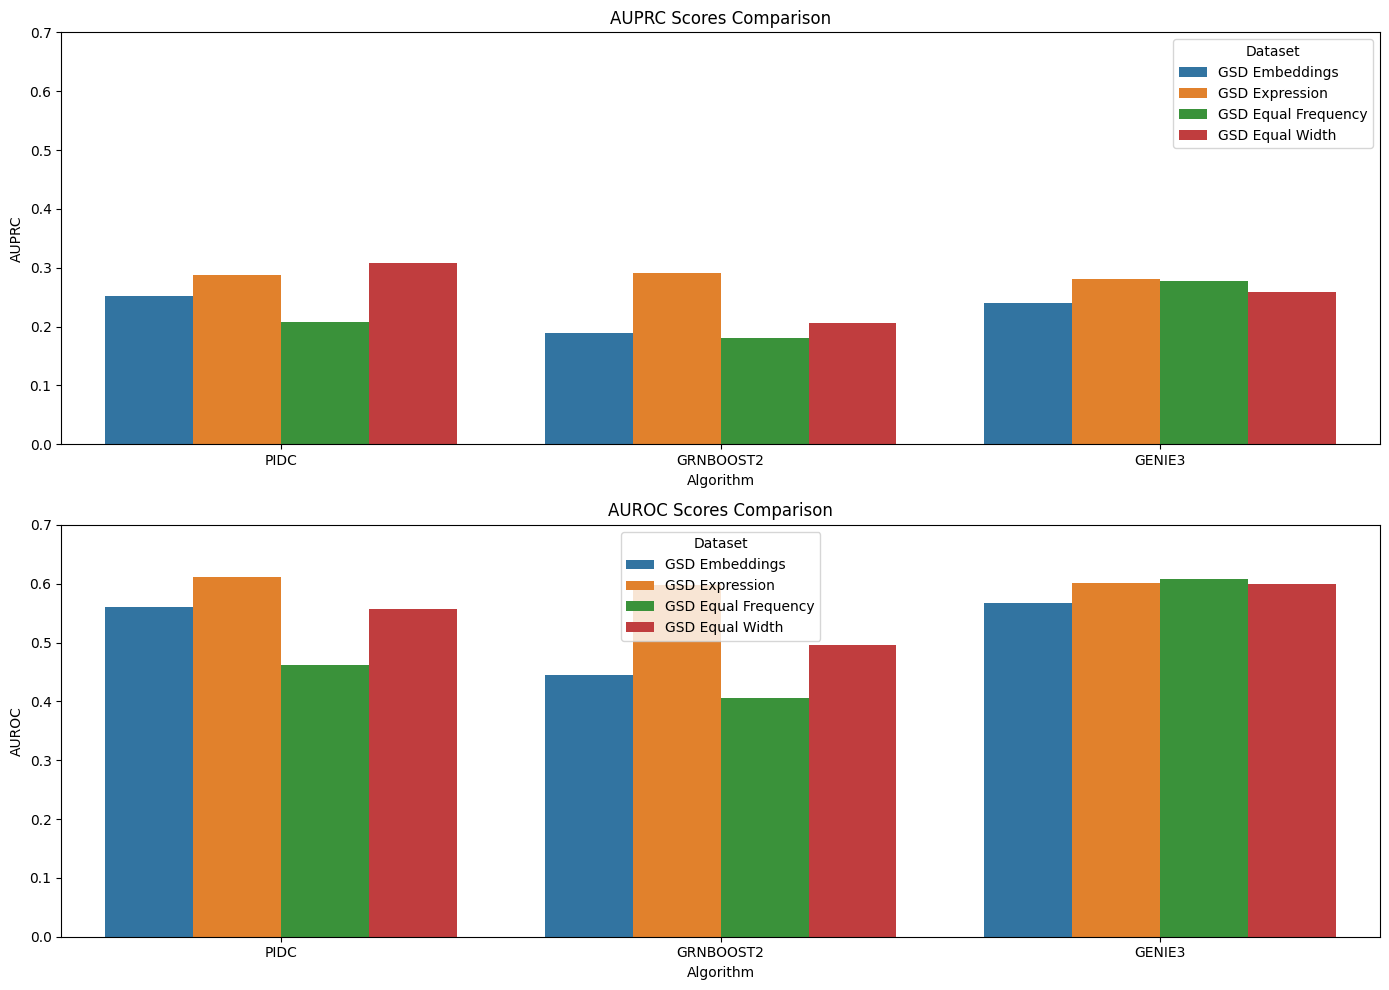

In [5]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 10))

# Plotting AUPRC
plt.subplot(2, 1, 1)
sns.barplot(x='Algorithm', y='AUPRC', hue='Dataset', data=df)
plt.title('AUPRC Scores Comparison')
plt.ylim(0, 0.7)

# Plotting AUROC
plt.subplot(2, 1, 2)
sns.barplot(x='Algorithm', y='AUROC', hue='Dataset', data=df)
plt.title('AUROC Scores Comparison')
plt.ylim(0, 0.7)

# Adjust layout
plt.tight_layout()
plt.show()


### 2. HSC Data

In [6]:
# Creating the data as pandas DataFrame
data = {
    'Dataset': ['HSC Embeddings (All_human_512)', 'HSC Embeddings (All_human_512)', 'HSC Embeddings (All_human_512)',
                'HSC Embeddings (All_human_1024)', 'HSC Embeddings (All_human_1024)', 'HSC Embeddings (All_human_1024)', 
                'HSC Embeddings (blood_model_512)', 'HSC Embeddings (blood_model_512)', 'HSC Embeddings (blood_model_512)',
                'HSC Embeddings (blood_model_1024)','HSC Embeddings (blood_model_1024)','HSC Embeddings (blood_model_1024)',
                'HSC Expression', 'HSC Expression', 'HSC Expression'],
    'Algorithm': ['PIDC', 'GRNBOOST2', 'GENIE3', 
                  'PIDC', 'GRNBOOST2', 'GENIE3',
                  'PIDC', 'GRNBOOST2', 'GENIE3', 
                  'PIDC', 'GRNBOOST2', 'GENIE3',
                  'PIDC', 'GRNBOOST2', 'GENIE3'],
    'AUPRC': [0, 0.2308795057, 0.2062646847, 
              0, 0.2536902236, 0.2498920457,
              0, 0.3285741836, 0.1973120068, 
              0, 0.5769230769, 0.4958791209,
              0.4829010766,0.4152895032,0.4832099724],
    'AUROC': [0, 0.4908424908, 0.4473443223, 
              0, 0.543040293, 0.4903846154,
              0, 0.4299450549, 0.570970696, 
              0, 0.5769230769, 0.4958791209,
              0.7527472527, 0.7289377289, 0.7802197802]
}

df = pd.DataFrame(data)


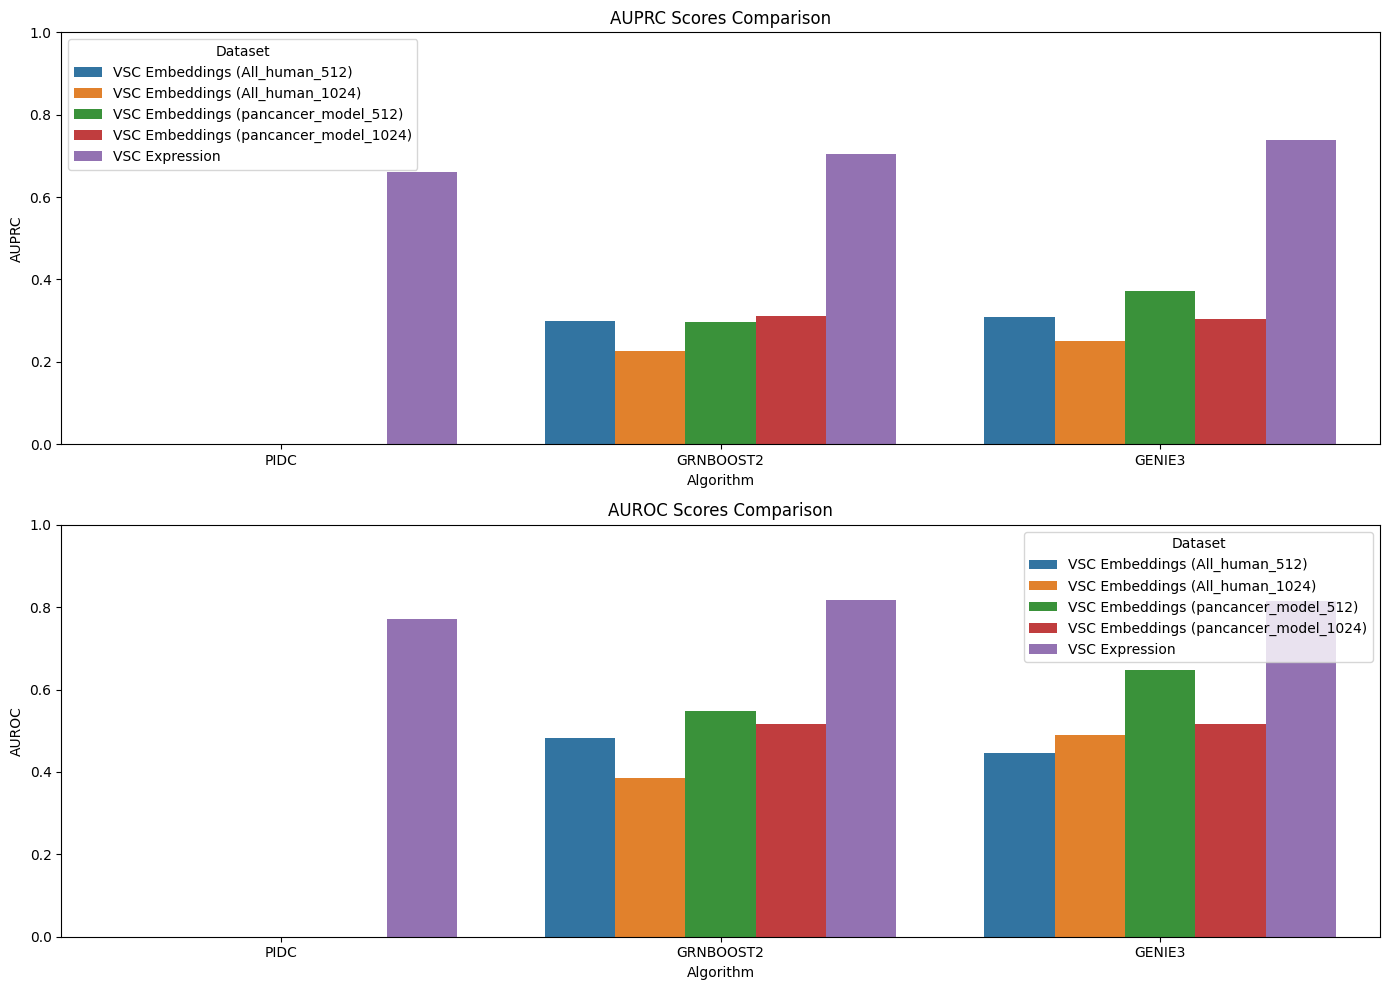

In [14]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 10))

# Plotting AUPRC
plt.subplot(2, 1, 1)
sns.barplot(x='Algorithm', y='AUPRC', hue='Dataset', data=df)
plt.title('AUPRC Scores Comparison')
plt.ylim(0, 1)

# Plotting AUROC
plt.subplot(2, 1, 2)
sns.barplot(x='Algorithm', y='AUROC', hue='Dataset', data=df)
plt.title('AUROC Scores Comparison')
plt.ylim(0, 1)

# Adjust layout
plt.tight_layout()
plt.show()

### 3. mCAD Data

In [8]:
# Parsing the CSV data
gene_embeddings_data = [
    ['scGPT_All_Human_512', 0, 0, 0.8213902582, 0.6923076923, 0.7058863172, 0.5714285714],
    ['scGPT_All_Human_1024', 0, 0, 0.6311106681, 0.3516483516, 0.7210487934, 0.6043956044],
    ['scGPT_pancancer_model_512', 0, 0, 0.5481805264, 0.3846153846, 0.6052734156, 0.5164835165],
    ['scGPT_pancancer_model_1024', 0, 0, 0.5930594534, 0.3186813187, 0.5472934139, 0.3296703297]
]

gene_expression_data = [
    [0.6603736243, 0.7715447154, 0.7042240407, 0.8178861789, 0.7392007502, 0.8146341463]
]

In [9]:
# Prepare the data dictionary
data = {
    'Dataset': ['mCAD Embeddings (All_human_512)', 'mCAD Embeddings (All_human_512)', 'mCAD Embeddings (All_human_512)',
                'mCAD Embeddings (All_human_1024)', 'mCAD Embeddings (All_human_1024)', 'mCAD Embeddings (All_human_1024)', 
                'mCAD Embeddings (pancancer_model_512)', 'mCAD Embeddings (pancancer_model_512)', 'mCAD Embeddings (pancancer_model_512)',
                'mCAD Embeddings (pancancer_model_1024)', 'mCAD Embeddings (pancancer_model_1024)', 'mCAD Embeddings (pancancer_model_1024)',
                'mCAD Expression', 'mCAD Expression', 'mCAD Expression'],
    'Algorithm': ['PIDC', 'GRNBOOST2', 'GENIE3', 
                  'PIDC', 'GRNBOOST2', 'GENIE3',
                  'PIDC', 'GRNBOOST2', 'GENIE3', 
                  'PIDC', 'GRNBOOST2', 'GENIE3',
                  'PIDC', 'GRNBOOST2', 'GENIE3'],
    'AUPRC': [gene_embeddings_data[0][1], gene_embeddings_data[0][3], gene_embeddings_data[0][5],
              gene_embeddings_data[1][1], gene_embeddings_data[1][3], gene_embeddings_data[1][5],
              gene_embeddings_data[2][1], gene_embeddings_data[2][3], gene_embeddings_data[2][5],
              gene_embeddings_data[3][1], gene_embeddings_data[3][3], gene_embeddings_data[3][5],
              gene_expression_data[0][0], gene_expression_data[0][2], gene_expression_data[0][4]],
    'AUROC': [gene_embeddings_data[0][2], gene_embeddings_data[0][4], gene_embeddings_data[0][6],
              gene_embeddings_data[1][2], gene_embeddings_data[1][4], gene_embeddings_data[1][6],
              gene_embeddings_data[2][2], gene_embeddings_data[2][4], gene_embeddings_data[2][6],
              gene_embeddings_data[3][2], gene_embeddings_data[3][4], gene_embeddings_data[3][6],
              gene_expression_data[0][1], gene_expression_data[0][3], gene_expression_data[0][5]]
}


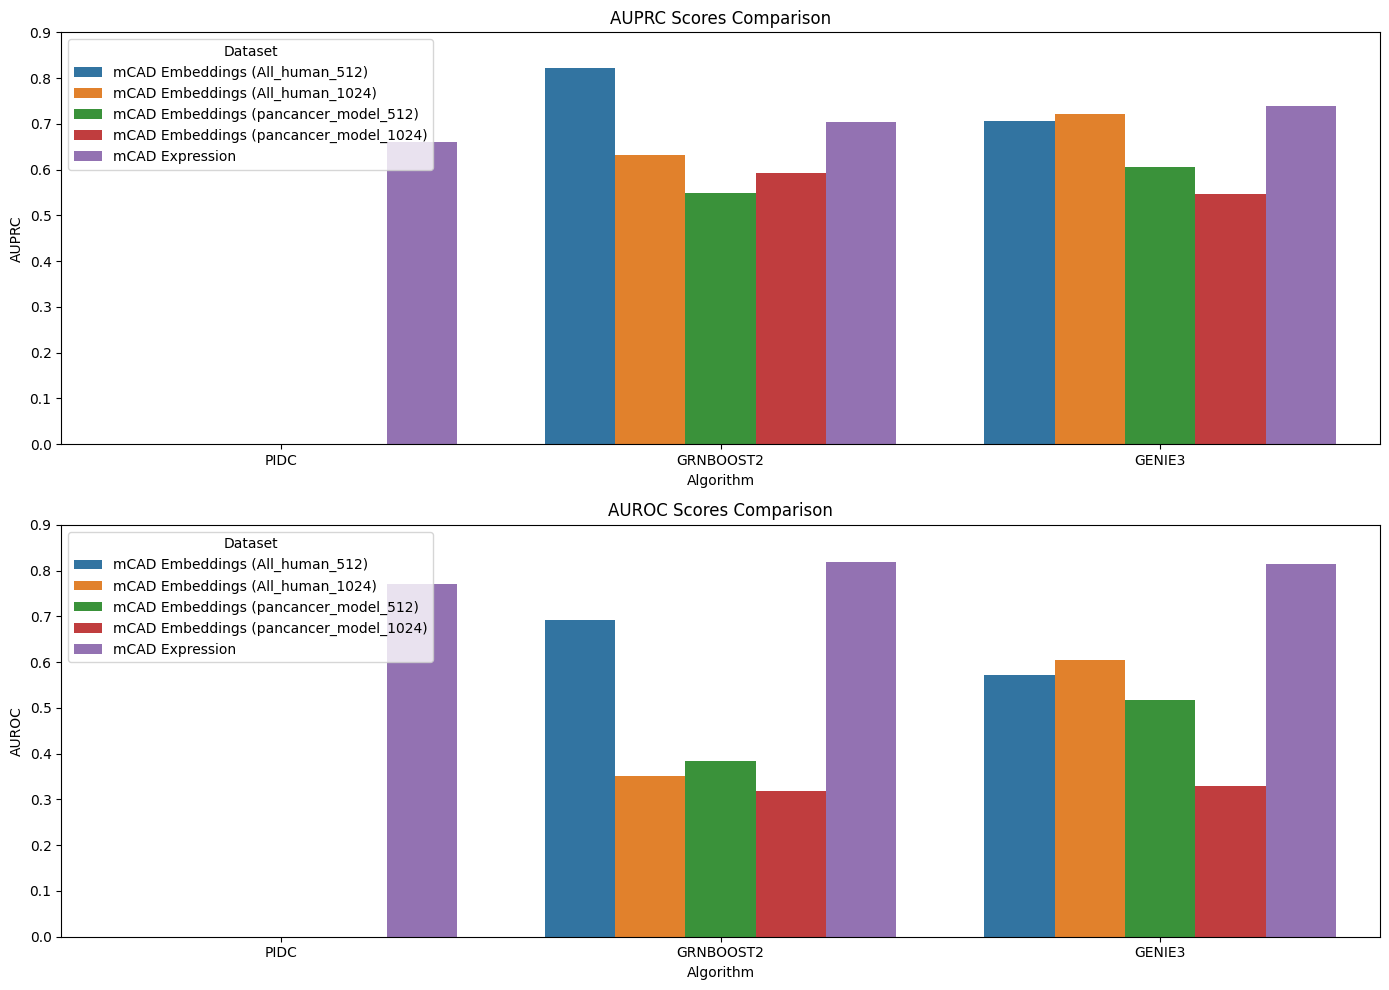

In [10]:
df = pd.DataFrame(data)
# Set up the matplotlib figure
plt.figure(figsize=(14, 10))

# Plotting AUPRC
plt.subplot(2, 1, 1)
sns.barplot(x='Algorithm', y='AUPRC', hue='Dataset', data=df)
plt.title('AUPRC Scores Comparison')
plt.ylim(0, 0.9)

# Plotting AUROC
plt.subplot(2, 1, 2)
sns.barplot(x='Algorithm', y='AUROC', hue='Dataset', data=df)
plt.title('AUROC Scores Comparison')
plt.ylim(0, 0.9)

# Adjust layout
plt.tight_layout()
plt.show()

### 4. VSC Data

In [11]:
# Parsing the CSV data
gene_embeddings_data = [
    ['scGPT_All_Human_512', 0,	0,	0.2988689118, 0.481300813, 0.3091602753, 0.4455284553],
    ['scGPT_All_Human_1024', 0, 0, 0.2270764461, 0.3853658537, 0.2508058166, 0.4894308943],
    ['scGPT_blood_model_512', 0 ,0, 0.2962285579, 0.5479674797, 0.3718425846, 0.6471544715],
    ['scGPT_blood_model_1024', 0, 0, 0.3104425824	,0.5154471545	,0.3047274848	,0.5154471545]
]

gene_expression_data = [
    [0.6603736243	,0.7715447154	,0.7042240407	,0.8178861789	,0.7392007502, 0.8146341463]
]

In [12]:
# Prepare the data dictionary
data = {
    'Dataset': ['VSC Embeddings (All_human_512)', 'VSC Embeddings (All_human_512)', 'VSC Embeddings (All_human_512)',
                'VSC Embeddings (All_human_1024)', 'VSC Embeddings (All_human_1024)', 'VSC Embeddings (All_human_1024)', 
                'VSC Embeddings (pancancer_model_512)', 'VSC Embeddings (pancancer_model_512)', 'VSC Embeddings (pancancer_model_512)',
                'VSC Embeddings (pancancer_model_1024)', 'VSC Embeddings (pancancer_model_1024)', 'VSC Embeddings (pancancer_model_1024)',
                'VSC Expression', 'VSC Expression', 'VSC Expression'],
    'Algorithm': ['PIDC', 'GRNBOOST2', 'GENIE3', 
                  'PIDC', 'GRNBOOST2', 'GENIE3',
                  'PIDC', 'GRNBOOST2', 'GENIE3', 
                  'PIDC', 'GRNBOOST2', 'GENIE3',
                  'PIDC', 'GRNBOOST2', 'GENIE3'],
    'AUPRC': [gene_embeddings_data[0][1], gene_embeddings_data[0][3], gene_embeddings_data[0][5],
              gene_embeddings_data[1][1], gene_embeddings_data[1][3], gene_embeddings_data[1][5],
              gene_embeddings_data[2][1], gene_embeddings_data[2][3], gene_embeddings_data[2][5],
              gene_embeddings_data[3][1], gene_embeddings_data[3][3], gene_embeddings_data[3][5],
              gene_expression_data[0][0], gene_expression_data[0][2], gene_expression_data[0][4]],
    'AUROC': [gene_embeddings_data[0][2], gene_embeddings_data[0][4], gene_embeddings_data[0][6],
              gene_embeddings_data[1][2], gene_embeddings_data[1][4], gene_embeddings_data[1][6],
              gene_embeddings_data[2][2], gene_embeddings_data[2][4], gene_embeddings_data[2][6],
              gene_embeddings_data[3][2], gene_embeddings_data[3][4], gene_embeddings_data[3][6],
              gene_expression_data[0][1], gene_expression_data[0][3], gene_expression_data[0][5]]
}


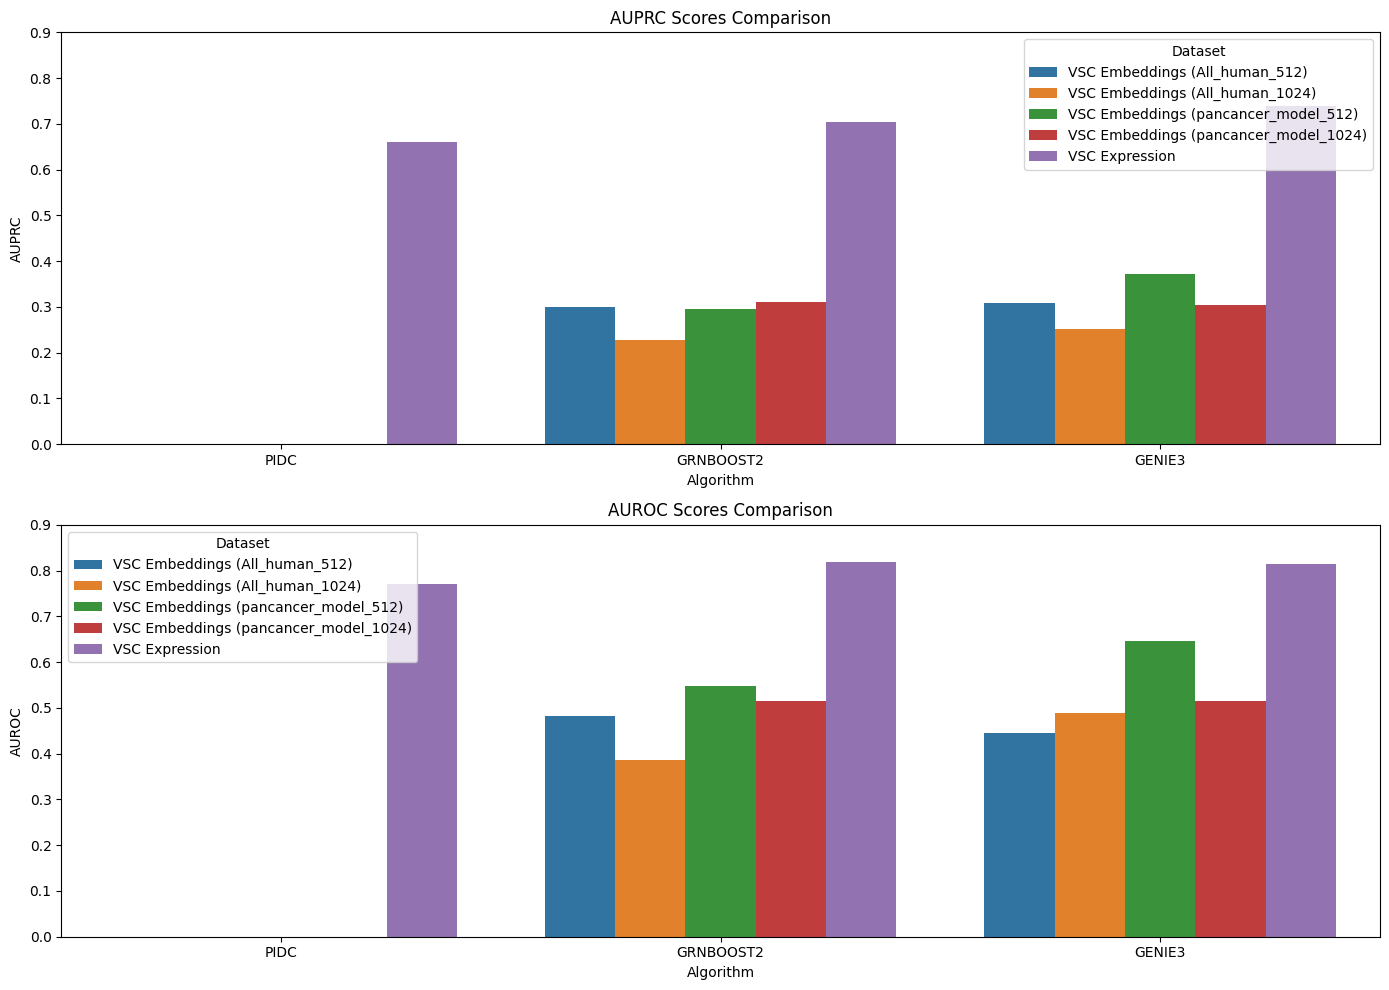

In [13]:
df = pd.DataFrame(data)
# Set up the matplotlib figure
plt.figure(figsize=(14, 10))

# Plotting AUPRC
plt.subplot(2, 1, 1)
sns.barplot(x='Algorithm', y='AUPRC', hue='Dataset', data=df)
plt.title('AUPRC Scores Comparison')
plt.ylim(0, 0.9)

# Plotting AUROC
plt.subplot(2, 1, 2)
sns.barplot(x='Algorithm', y='AUROC', hue='Dataset', data=df)
plt.title('AUROC Scores Comparison')
plt.ylim(0, 0.9)

# Adjust layout
plt.tight_layout()
plt.show()